# 1. Import required modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import data
import skimage
from skimage.filters.thresholding import threshold_li,threshold_local,threshold_otsu
from skimage.morphology import erosion, dilation, opening, closing, white_tophat, remove_small_objects, ball
from skimage.morphology import disk
from scipy import ndimage as ndi
import sys,os, glob

#import skimage.filters.median

#import skimage.segmentation as seg
#import skimage.filters as filters
#import skimage.draw as draw
#import skimage.color as color

#from skimage.filters.thresholding import _cross_entropy
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image


#pip install nd2reader_required for nd2 file reading
from nd2reader import ND2Reader

import pandas as pd

c:\programdata\anaconda3\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# 2. Define common parameters for measurement loading here:

In [18]:
# The labeled histone mark in the excel

h2ax_key = 'H3K27ac'


# the actual histone mark analyzed  (to correct the mis-labeling in the raw measurements)
actual_h2ax_key = 'H3K27ac'


In [4]:
data_folder = r'D:\Analyzed_CellBio\Stam\Revision_exps_p2\T2p1_h3k27ac_analysis'
data_df = pd.read_excel(os.path.join(data_folder, 'T2p1_mdc-488_baf_h3k27ac_analyzed_size300_pos_filtered.xlsx'),index_col=None)

In [5]:
data_df

exp_annotation  Unnamed: 0          exp_name  \
0    220623IF_220621exp           0  220623IF_H3K27ac   
1    220623IF_220621exp           0  220623IF_H3K27ac   
2    220623IF_220621exp           0  220623IF_H3K27ac   
3    220623IF_220621exp           0  220623IF_H3K27ac   
4    220623IF_220621exp           0  220623IF_H3K27ac   
..                  ...         ...               ...   
164  220728IF_220621exp           0  220728IF_H3K27ac   
165  220728IF_220621exp           0  220728IF_H3K27ac   
166  220728IF_220621exp           0  220728IF_H3K27ac   
167  220728IF_220621exp           0  220728IF_H3K27ac   
168  220728IF_220621exp           0  220728IF_H3K27ac   

                                           position_id  cell_id  \
0    220620 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        7   
1    220620 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        3   
2    220620 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        7   
3    220620 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        1   
4    220620 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        4   
..                                                 ...      ...   
164  220721 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        4   
165  220721 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        5   
166  220721 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        4   
167  220721 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        7   
168  220721 RPE1 T2p1 fix6h BAF-GFP Mdc1-568 H3K27a...        9   

        cell_xyz_coord  area_incorporated_chr  \
0    [[1177, 1108], 4]                    477   
1      [[934, 848], 3]                    321   
2    [[1085, 1090], 4]                    517   
3     [[1378, 674], 4]                    483   
4     [[1183, 891], 4]                    626   
..                 ...                    ...   
164   [[968, 1133], 2]                    415   
165  [[1091, 1024], 2]                    548   
166   [[1055, 958], 4]                    820   
167   [[791, 1073], 3]                    341   
168   [[985, 1392], 3]                    368   

     area_h2ax_within_incorporated_chr  \
0                                    0   
1                                    1   
2                                   60   
3                                    0   
4                                    5   
..                                 ...   
164                                  1   
165                                  1   
166                                  1   
167                                  1   
168                                  0   

     area_less_h2ax_within_incorporated_chr  area_control_chr  ...  \
0                                       477             20382  ...   
1                                       320             12592  ...   
2                                       457             19260  ...   
3                                       483             38173  ...   
4                                       621             21296  ...   
..                                      ...               ...  ...   
164                                     414             12843  ...   
165                                     547             24564  ...   
166                                     819             21975  ...   
167                                     340             23938  ...   
168                                     368             21669  ...   

     ave_intensity_h2ax_less_incorporated_chr_H3K27ac  normalized_inc_H3K27ac  \
0                                           20.200996                0.631331   
1                                          113.284526                0.660769   
2                                          111.491753                0.651046   
3                                         1045.735978                0.886478   
4                                         1141.760139                1.110557   
..                                                ...                     ...   
164              

## Size filtering

In [54]:
_exp_df = data_df.copy()

In [55]:
size_th =415

_exp_df= _exp_df[_exp_df['area_incorporated_chr']>size_th].copy()
print (f'-- There are {len(_exp_df)} data-points after filtering.')
#exp_analysis_savename = _exp_key+'_'+analysis_filtered_savename
#_exp_df.to_excel(os.path.join(analysis_save_path,exp_analysis_savename), index=False)
    


-- There are 119 data-points after filtering.


## Position filtering

In [61]:
def filter_cell_by_coord (xyz_coord_str, bound1=2048, bound2=0, dist_tp_bound = 900):
    
    xy_coord_str = xyz_coord_str.split('],')[0].split('[[')[-1]
    # note here xy is symetric; otherwise need to check which is x and which is y
    x=int(xy_coord_str.split(',')[0])
    y=int(xy_coord_str.split(',')[1])
    
    if abs(x-bound1)>=dist_tp_bound and abs(y-bound1)>=dist_tp_bound:
        if abs(x-bound2)>=dist_tp_bound and abs(y-bound2)>=dist_tp_bound:
            result= 1
        else:
            result= 0
    else:
        result= 0

    return result
        
    
_exp_key = 'T2p1'
analysis_save_path = r'D:\Analyzed_CellBio\Stam\Revision_exps_p2\T2p1_h3k27ac_analysis'
exp_analysis_savename= f'T2p1_mdc-488_baf_h3k27ac_analyzed_size{size_th}_pos_filtered.xlsx'



# size filtering
_exp_df= _exp_df[_exp_df['area_incorporated_chr']>size_th].copy()
print (f'-- There are {len(_exp_df)} data-points after size filtering.')
# postion filtering
_exp_df['pos_kept']=_exp_df['cell_xyz_coord'].map(lambda x: filter_cell_by_coord(x))
_exp_df=_exp_df[_exp_df['pos_kept']==1].copy()
print (f'-- There are {len(_exp_df)} data-points after position filtering.')
#exp_analysis_savename = _exp_key+'_'+analysis_filtered_savename
_exp_df.to_excel(os.path.join(analysis_save_path,exp_analysis_savename), index=False)


-- There are 51 data-points after size filtering.
-- There are 51 data-points after position filtering.


MW comparision: 2.3907412199268652e-12


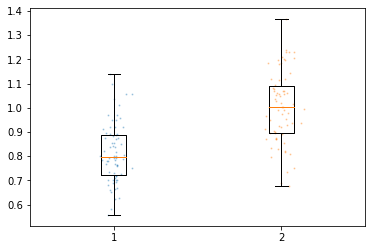

In [50]:
# for dna

# 
g1 = _exp_df['normalized_inc_dna']
g2 = _exp_df['normalized_subset_control_dna']
#g3 = out_df_dict['HDACi']['normalized_inc_dna']
#g4 = out_df_dict['HDACi']['normalized_subset_control_dna']

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)
#args = (g1,g2,g3,g4)
args = (g1,g2)


boxplot_pol2= plt.boxplot([*args], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([*args]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 1, alpha=0.3)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



#print(f"three samples comparision: {p4}")

MW comparision: 9.085779848194186e-25


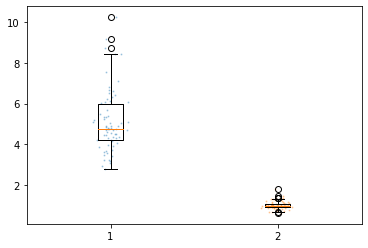

In [51]:
# for mdc1

g1 = _exp_df['normalized_inc_Mdc1']
g2 = _exp_df['normalized_subset_control_Mdc1']
#g3 = out_df_dict['HDACi']['normalized_inc_Mdc1']
#g4 = out_df_dict['HDACi']['normalized_subset_control_Mdc1']

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)
#args = (g1,g2,g3,g4)
args = (g1,g2)

boxplot_pol2= plt.boxplot([*args], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([*args]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 1, alpha=0.3)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



#print(f"three samples comparision: {p4}")

MW comparision: 3.2651642667417105e-09


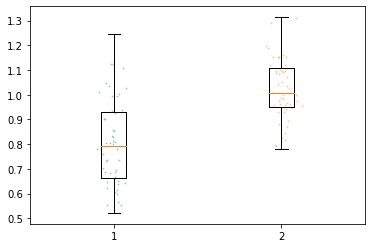

In [57]:
# For Pol2S5

g1 = _exp_df['normalized_inc_H3K27ac']
g2 = _exp_df['normalized_subset_control_H3K27ac']
#g3 = out_df_dict['HDACi']['normalized_inc_Pol2S5']
#g4 = out_df_dict['HDACi']['normalized_subset_control_Pol2S5']

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)
#args = (g1,g2,g3,g4)
args = (g1,g2)
boxplot_pol2= plt.boxplot([*args], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([*args]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 1, alpha=0.3)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



#print(f"three samples comparision: {p4}")

MW comparision: 0.09255969891293342


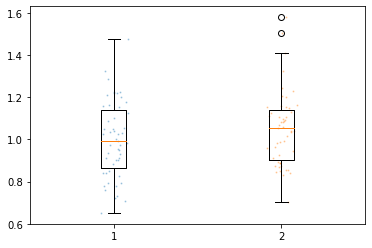

In [58]:
# For Pol2S5 norm to dna

g1 = (_exp_df['normalized_inc_H3K27ac'])/(_exp_df['normalized_inc_dna'])
g2 = (_exp_df['normalized_subset_control_H3K27ac'])/(_exp_df['normalized_subset_control_dna'])
#g3 = out_df_dict['HDACi']['normalized_inc_Pol2S5']/(out_df_dict['HDACi']['normalized_inc_dna'])
#g4 = out_df_dict['HDACi']['normalized_subset_control_Pol2S5']/(out_df_dict['HDACi']['normalized_subset_control_dna'])

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)
#args = (g1,g2,g3,g4)
args = (g1,g2)

boxplot_pol2= plt.boxplot([*args], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([*args]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 1, alpha=0.3)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



#print(f"three samples comparision: {p4}")

MW comparision: 1.4371637997014966e-09


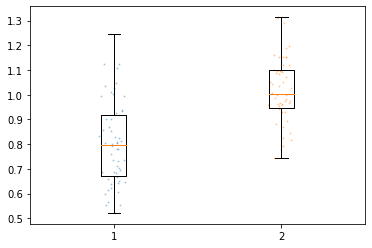

In [19]:
# For H2ax-key relevant Ab


g1 = (_exp_df[f'normalized_inc_{actual_h2ax_key}'])
g2 = (_exp_df[f'normalized_subset_control_{actual_h2ax_key}'])
#g3 = out_df_dict['HDACi'][f'normalized_inc_{actual_h2ax_key}']
#g4 = out_df_dict['HDACi'][f'normalized_subset_control_{actual_h2ax_key}']

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)
#args = (g1,g2,g3,g4)
args = (g1,g2)

boxplot_pol2= plt.boxplot([*args], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([*args]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 1, alpha=0.3)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



#print(f"three samples comparision: {p4}")

MW comparision: 2.8528584013639845e-06


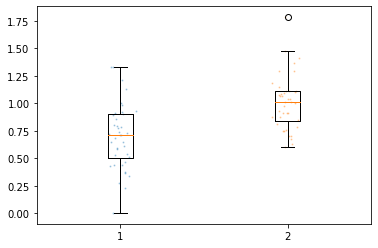

In [18]:
# For H2ax-key relevant Ab


g1 = (out_df_dict['Asy'][f'normalized_inc_{actual_h2ax_key}'])/(out_df_dict['Asy']['normalized_inc_dna'])
g2 = (out_df_dict['Asy'][f'normalized_subset_control_{actual_h2ax_key}'])/(out_df_dict['Asy']['normalized_subset_control_dna'])
#g3 = out_df_dict['HDACi'][f'normalized_inc_{actual_h2ax_key}']/(out_df_dict['HDACi']['normalized_inc_dna'])
#g4 = out_df_dict['HDACi'][f'normalized_subset_control_{actual_h2ax_key}']/(out_df_dict['HDACi']['normalized_subset_control_dna'])

#sp_low = min(len(g1),len(g2),len(g3))
#sp_low = min(len(g1),len(g2), len(g3))

#g1 = np.random.choice(g1, sp_low)
#g2 = np.random.choice(g2, sp_low)
#g3 = np.random.choice(g3, sp_low)
#g4 = np.random.choice(g4, sp_low)
#args = (g1,g2,g3,g4)
args = (g1,g2)

boxplot_pol2= plt.boxplot([*args], meanline = True)


vals, xs = [], [] 

for i, subdf in enumerate([*args]):
    #names.append(name)
    vals.append(subdf.tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))

for x, val in zip(xs, vals):
    plt.scatter(x, val,  s = 1, alpha=0.3)

from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
#p4 = kruskal(g1,g2,g3,g4)

U1, p1 = mannwhitneyu(g1,g2)

print(f"MW comparision: {p1}")



#print(f"three samples comparision: {p4}")

In [26]:
from scipy import stats
stats.spearmanr(_exp_df['normalized_inc_Pol2S5'], _exp_df[f'normalized_inc_{actual_h2ax_key}'])

SpearmanrResult(correlation=0.8117113195418125, pvalue=1.2950853356059274e-40)

In [43]:
plt.scatter(x= out_df_dict['HDACi']['normalized_inc_Pol2S5'], y =out_df_dict['HDACi'][f'normalized_inc_{actual_h2ax_key}'])


KeyError: 'HDACi'